In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import re
import statsmodels.api as sm
import statsmodels.formula.api as smf
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation, performance_metrics
from datetime import datetime
import geopandas as gpd
import sys
sys.path.append('energy/')
import utils
from hts import hts, orderHier
%matplotlib inline

In [3]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
warnings.simplefilter("ignore", FutureWarning)

In [4]:
pd.options.mode.chained_assignment = None  # default='warn'

In [5]:
#viz setup
# sns.set(style='whitegrid',font_scale=1.75,rc={"axes.spines.top":False,"axes.spines.right":False, "lines.linewidth": 2.5,'lines.markersize': 10},color_codes=False,palette=sns.color_palette(['#27a3aa','#f76d23','#70d6e3','#ffbb31','#b1c96d','#cce18a','#1c4c5d','#787642']))
sns.set(style='whitegrid',font_scale=1.25,rc={"axes.spines.top":False,"axes.spines.right":False, "lines.linewidth": 2.5,'lines.markersize': 10},color_codes=False,palette=sns.color_palette(['#27a3aa','#f76d23','#70d6e3','#ffbb31','#b1c96d','#cce18a','#1c4c5d','#787642']))

In [6]:
energy_data = pd.read_csv('energy_data.csv')

In [7]:
energy_data.date = pd.to_datetime(energy_data.date)

In [8]:
energy_data = energy_data.dropna()
energy_data = energy_data[energy_data.consumers > 0]

In [9]:
energy_data.head()

,month,sales_mkwh,state,sector,consumers,price,revenue,use_per_capita,region,cooling_days,...,RES,time,year,mon,season,date,num_days,num_hols,pct_weekdays,y
0,202101,3164.80449,AL,RES,2284207.0,12.38,39180.279586,1385.515625,ESC,5.622370,...,1,157,2021,1,winter,2021-01-01,31,12,0.612903,44.694052
1,202012,2992.76542,AL,RES,2326166.0,11.39,34087.598134,1286.565714,ESC,1.125024,...,1,156,2020,12,winter,2020-12-01,31,9,0.709677,41.502120
2,202011,2056.87325,AL,RES,2324212.0,12.99,26718.783518,884.976607,ESC,13.247228,...,1,155,2020,11,fall,2020-11-01,30,11,0.633333,29.499220
3,202010,2150.98005,AL,RES,2326554.0,13.17,28328.407259,924.534763,ESC,67.266534,...,1,154,2020,10,fall,2020-10-01,31,10,0.677419,29.823702
4,202009,2876.36566,AL,RES,2325509.0,13.18,37910.499399,1236.875738,ESC,210.462990,...,1,153,2020,9,fall,2020-09-01,30,9,0.700000,41.229191


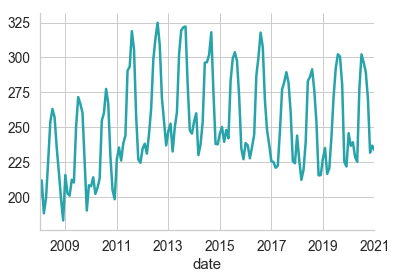

In [10]:
energy_data[(energy_data.state == 'TX')&(energy_data.sector=='COM')].set_index('date').sort_index().y.plot()

#### Removing outliers

In [11]:
energy_data = energy_data.set_index('date')

In [12]:
filtered_data = energy_data.groupby(['state','sector']).apply(utils.median_filter).reset_index()

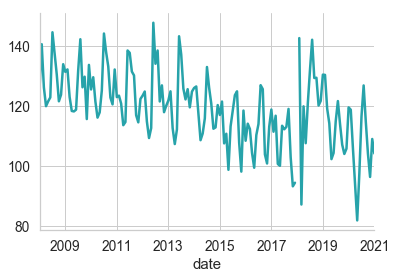

In [13]:
filtered_data[(filtered_data.state=='ME')&(filtered_data.sector=='COM')].set_index('date').y.plot()

In [14]:
energy_data = energy_data.reset_index().drop(columns='y').merge(filtered_data,how='left',on=['date','state','sector'])

## Heirarchical prophet

In [ ]:
heir_energy_data = energy_data.copy()
heir_energy_data.y = heir_energy_data.y/heir_energy_data.pct_weekdays
heir_energy_data, nodes = orderHier(heir_energy_data[(heir_energy_data.year<2019)&(heir_energy_data.region=='ESC')&(heir_energy_data.sector=='RES')][['date','state','y']],1)

In [ ]:
heir_energy_data.head()

In [ ]:
myDict = hts(heir_energy_data, 21, nodes, freq='MS', method = "OLS",yearly_seasonality=5,weekly_seasonality=False, daily_seasonality=False,mcmc_samples=300, changepoint_prior_scale=0.01,include_history =True)

In [ ]:
tmp = energy_data[(energy_data.state=='AL')&(energy_data.sector=='RES')]
tmp = tmp[['date','y','pct_weekdays']].merge(myDict['AL'][['ds','yhat']],how='left',left_on=['date'],right_on='ds').set_index('date')
tmp.yhat = tmp.yhat*tmp.pct_weekdays
tmp[['y','yhat']].plot()

In [ ]:
tmp.loc[:,['y','yhat']].corr()

## FB Prophet analysis

Prediction Correlation: 0.971320595801408


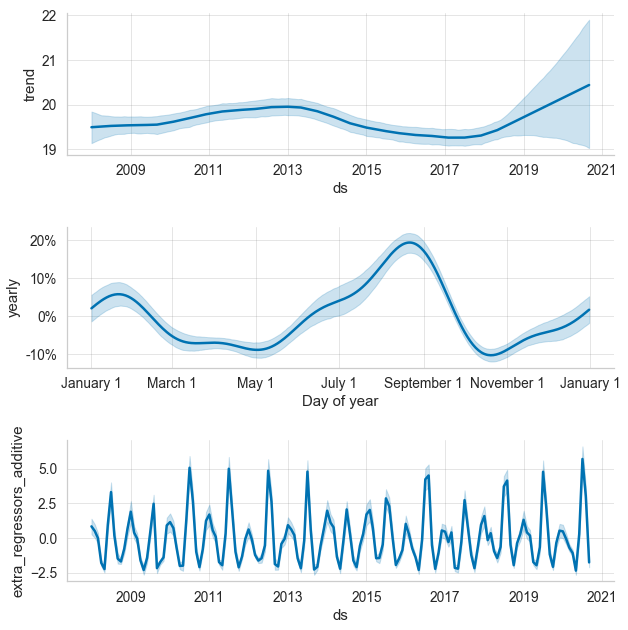

In [15]:
utils.get_model_for_state_sector(energy_data,'NY','RES',changepoint_prior_scale=0.1)

Prediction Correlation: 0.9923411741230233


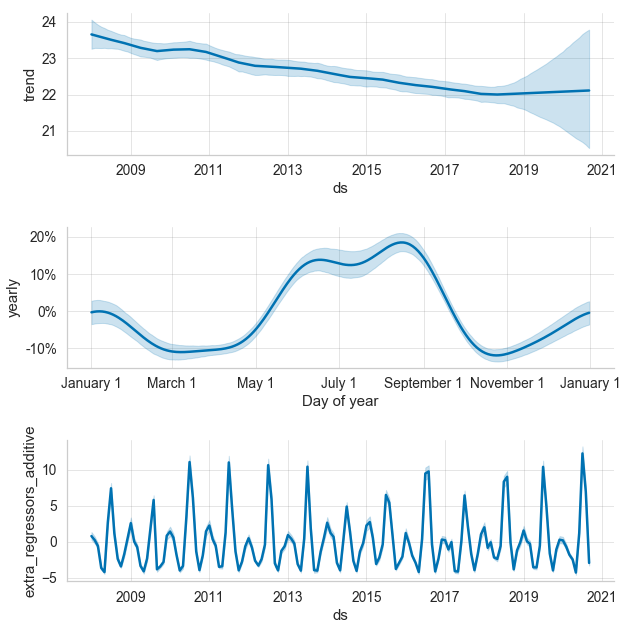

In [16]:
utils.get_model_for_state_sector(energy_data,'NJ','RES',changepoint_prior_scale=0.1)

Prediction Correlation: 0.972734792038008


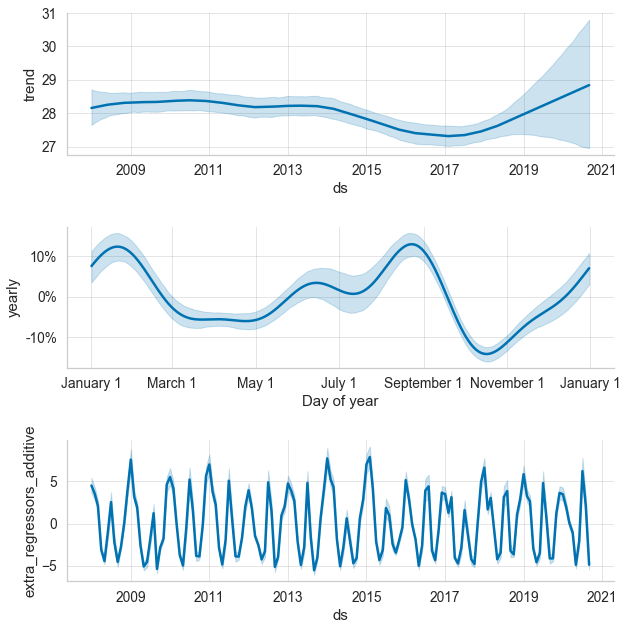

In [17]:
utils.get_model_for_state_sector(energy_data,'PA','RES',changepoint_prior_scale=0.1)

### Running for each State and Sector

In [19]:
# %%timeit
states = list(energy_data.state.unique())
sectors = list(energy_data.sector.unique())
idx = 0
for state in states:
    for sector in sectors:
        
        state_sector = "{}-{}".format(state, sector)
        print(state_sector)
        ## Defining Training Data 
        df_model = energy_data[(energy_data.state == state)&(energy_data.sector == sector)].copy().set_index('date').sort_index()
        df_train, df_test = utils.prepare_data(df_model[['y','heating_days','cooling_days','pct_weekdays']], 2019)
        regressors_df = df_model[['heating_days','cooling_days','pct_weekdays']].copy()
        
        ## Fitting model
        m = Prophet(seasonality_mode='multiplicative',
                yearly_seasonality=5,daily_seasonality=False,weekly_seasonality=False,mcmc_samples=300,
                changepoint_prior_scale=0.5, changepoint_range=0.95)
        m.add_regressor('heating_days', mode='additive')
        m.add_regressor('cooling_days', mode='additive')
        m.add_regressor('pct_weekdays', mode='additive')
        m_fit = m.fit(df_train,control={'max_treedepth': 12})
        
        ## Getting forecasts
        future = m_fit.make_future_dataframe(periods = 21, freq = 'MS')
        future = utils.add_regressor_to_future(future, regressors_df)
        forecast = m_fit.predict(future)
        # fig = m_fit.plot(forecast)
        forecast['state'] = state
        forecast['sector'] = sector
               
        if idx == 0:
            predictions = forecast[['ds','yhat','state','sector']].copy()    
        else:
            predictions = predictions.append(forecast[['ds','yhat','state','sector']])
            
        idx = idx +1


AL-RES
AL-COM


AZ-RES
AZ-COM


AR-RES
AR-COM


CA-RES
CA-COM
CO-RES
CO-COM


CT-RES
CT-COM
DC-RES
DC-COM
DE-RES
DE-COM
FL-RES
FL-COM
GA-RES
GA-COM


ID-RES
ID-COM
IL-RES


IL-COM
IN-RES


IN-COM


IA-RES


IA-COM


KS-RES
KS-COM


KY-RES
KY-COM
LA-RES
LA-COM


ME-RES


ME-COM
MD-RES
MD-COM
MA-RES
MA-COM


MI-RES
MI-COM


MN-RES


MN-COM


MS-RES
MS-COM
MO-RES
MO-COM


MT-RES
MT-COM
NE-RES
NE-COM


NV-RES
NV-COM
NH-RES
NH-COM
NJ-RES


NJ-COM
NM-RES
NM-COM


NY-RES
NY-COM


NC-RES
NC-COM
ND-RES
ND-COM


OH-RES
OH-COM


OK-RES
OK-COM
OR-RES


OR-COM
PA-RES
PA-COM


RI-RES
RI-COM
SC-RES
SC-COM
SD-RES
SD-COM


TN-RES
TN-COM


TX-RES
TX-COM


UT-RES
UT-COM
VT-RES
VT-COM


VA-RES
VA-COM
WA-RES
WA-COM
WV-RES
WV-COM
WI-RES
WI-COM


WY-RES
WY-COM


USA-RES


USA-COM


In [20]:
predictions = predictions.rename(columns={'ds':'date'})

In [21]:
predictions.head()

,date,yhat,state,sector
0,2008-01-01,49.332953,AL,RES
1,2008-02-01,43.895182,AL,RES
2,2008-03-01,34.987312,AL,RES
3,2008-04-01,30.929902,AL,RES
4,2008-05-01,34.229398,AL,RES


In [22]:
energy_data = energy_data.merge(predictions,how='left',on=['date','state','sector'])

In [23]:
correlations = energy_data[energy_data.year==2019].groupby(['state','sector']).apply(lambda x: np.corrcoef(x.y, x.yhat)[0, 1]).reset_index().rename(columns={0:'correl'})

In [24]:
energy_data['pct_error'] = (energy_data['y'] - energy_data['yhat'])*100/energy_data['y']

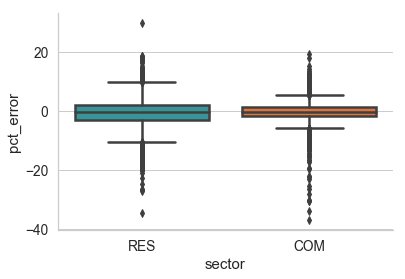

In [25]:
sns.boxplot(y='pct_error',x='sector',data=energy_data[energy_data.year<2020])

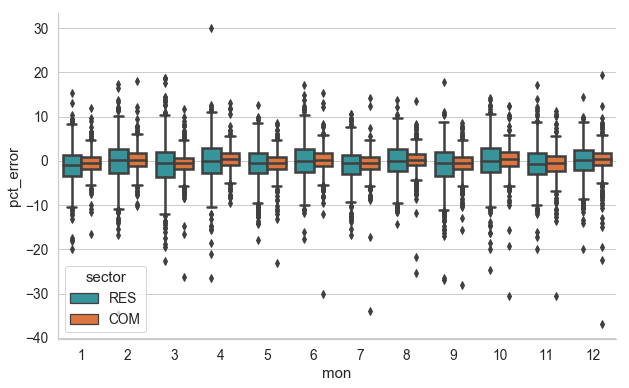

In [26]:
fig,ax = plt.subplots(figsize=(10,6))
sns.boxplot(y='pct_error',x='mon',hue='sector',data=energy_data[(energy_data.year<2020)])

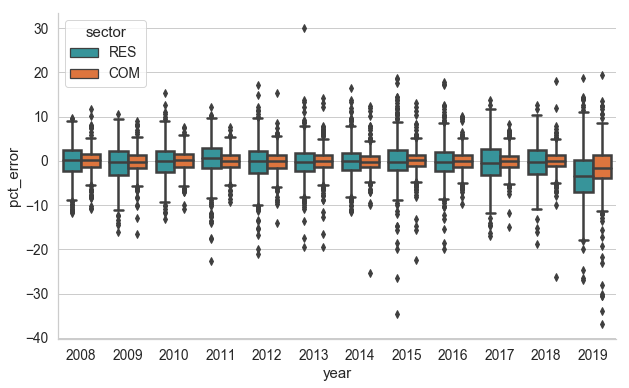

In [27]:
fig,ax = plt.subplots(figsize=(10,6))
sns.boxplot(y='pct_error',x='year',hue='sector',data=energy_data[(energy_data.year<2020)])

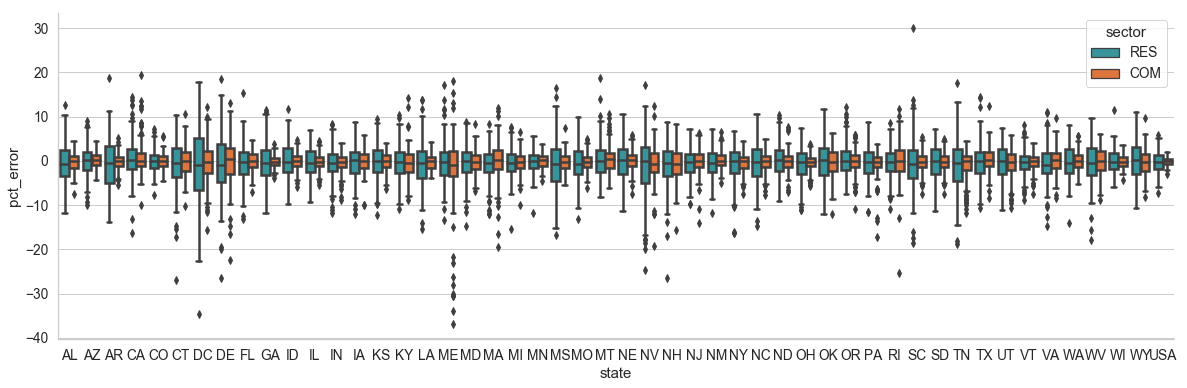

In [28]:
fig,ax = plt.subplots(figsize=(20,6))
sns.boxplot(y='pct_error',x='state',hue='sector',data=energy_data[(energy_data.year<2020)])

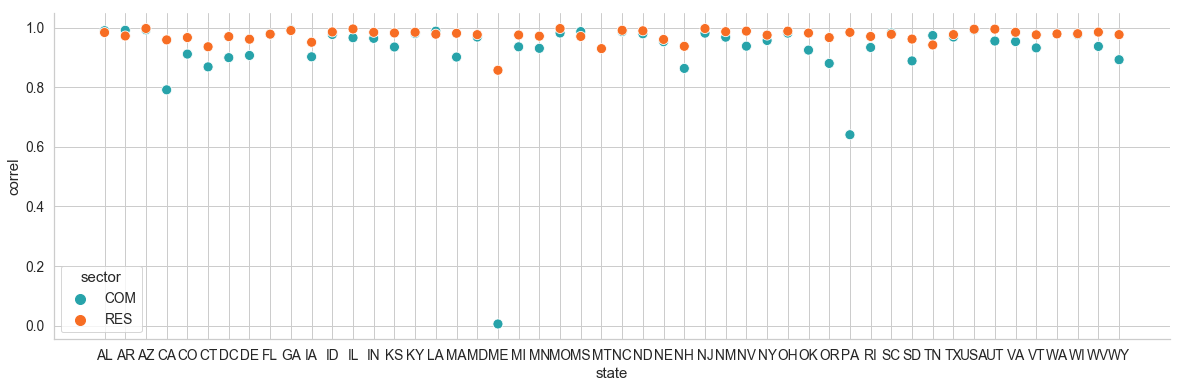

In [29]:
fig,ax = plt.subplots(figsize=(20,6))
sns.scatterplot(x='state',y='correl',hue='sector',data=correlations)

Prediction Correlation: 0.9690796555749823


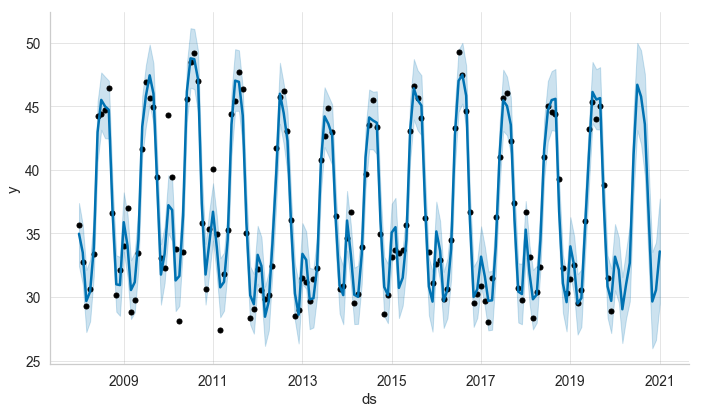

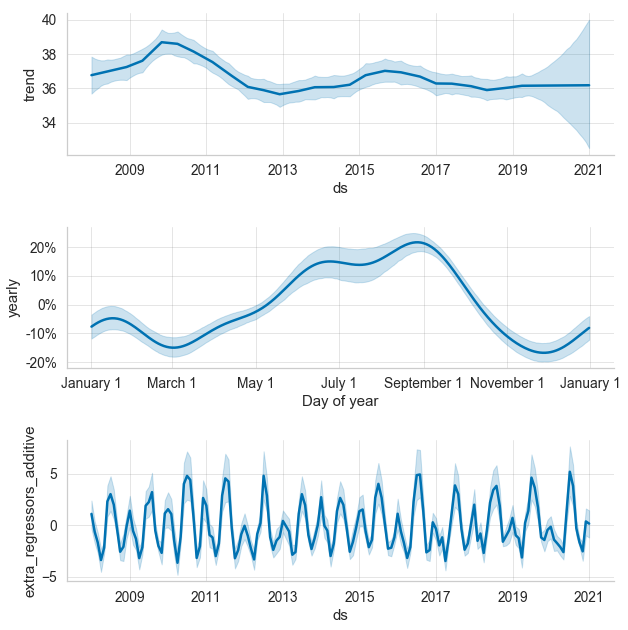

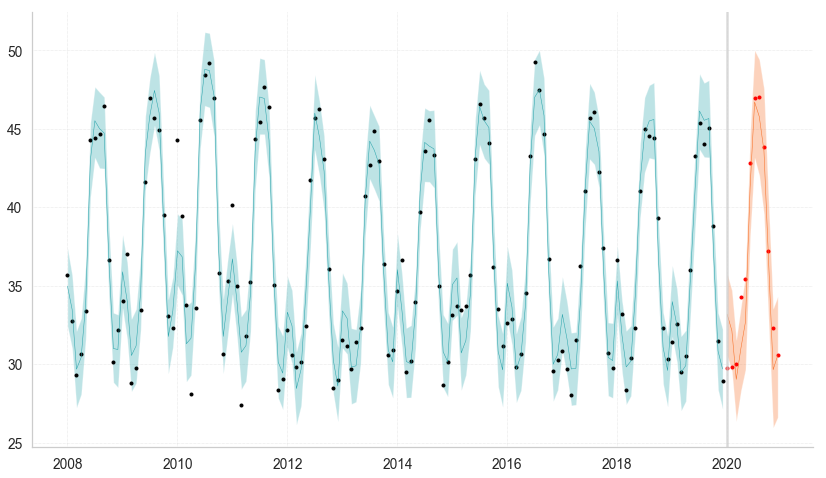

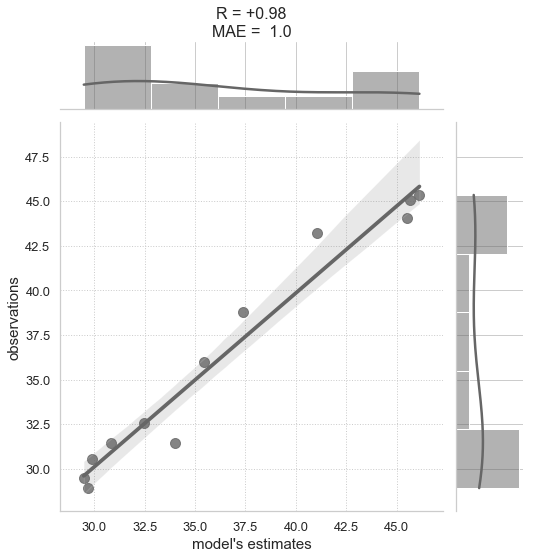

In [30]:
utils.get_model_for_state_sector(energy_data,'FL','RES',plot_forecast=True, changepoint_prior_scale=0.5,split_year=2020)

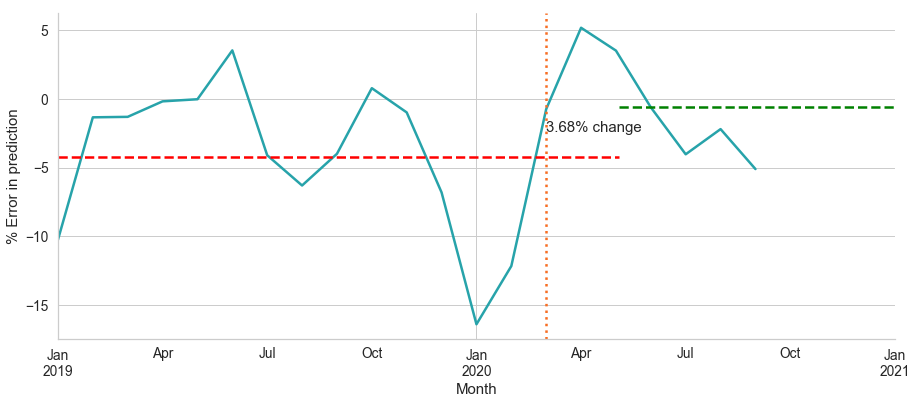

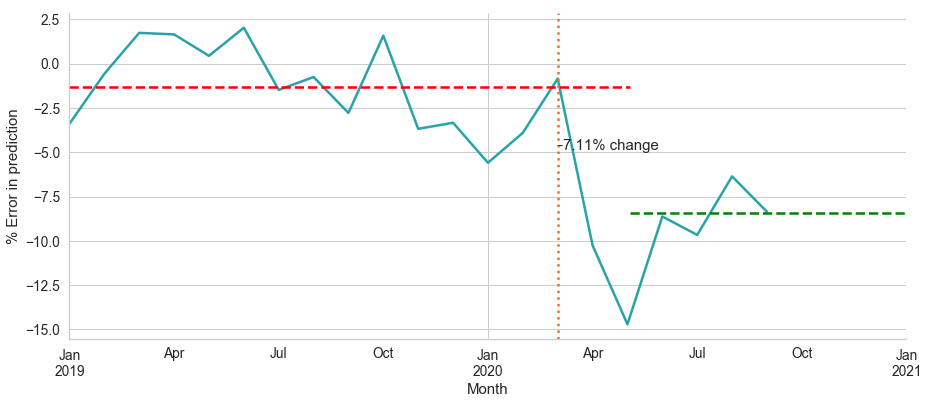

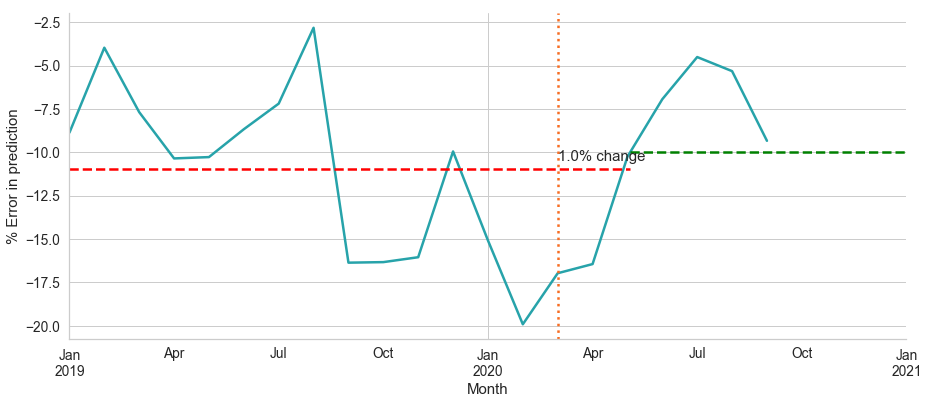

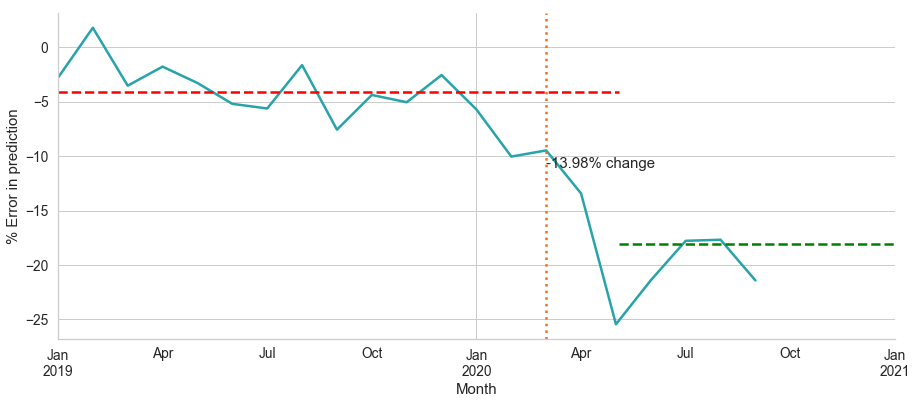

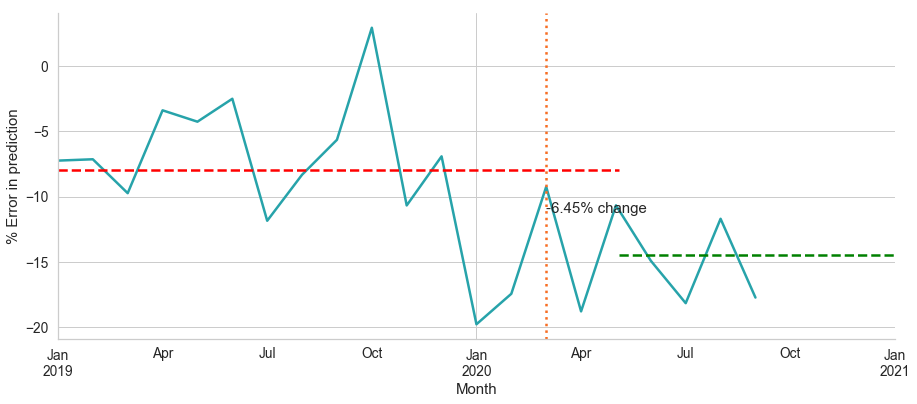

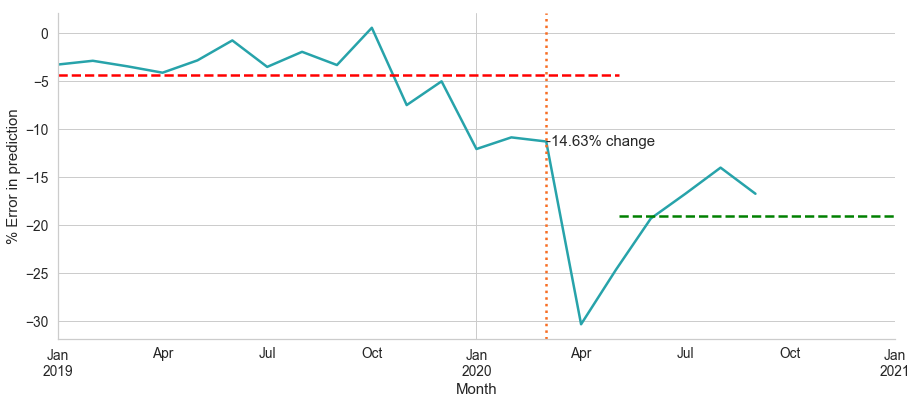

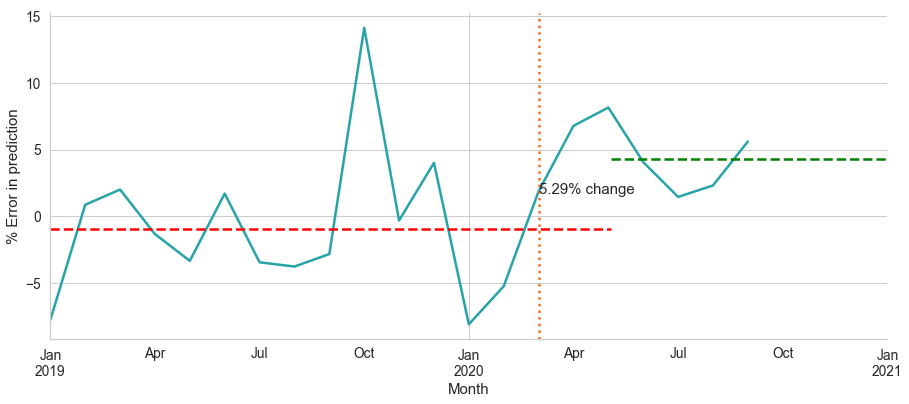

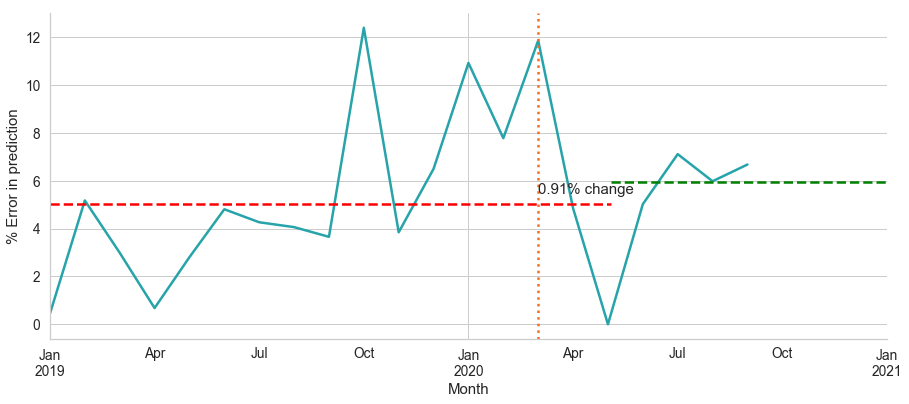

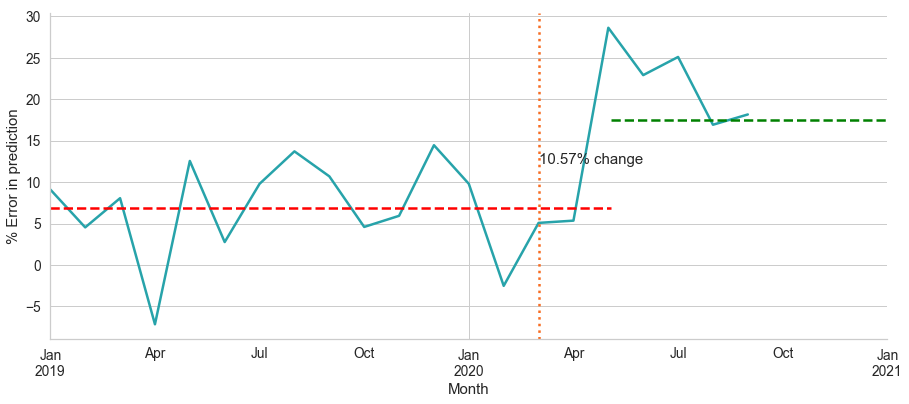

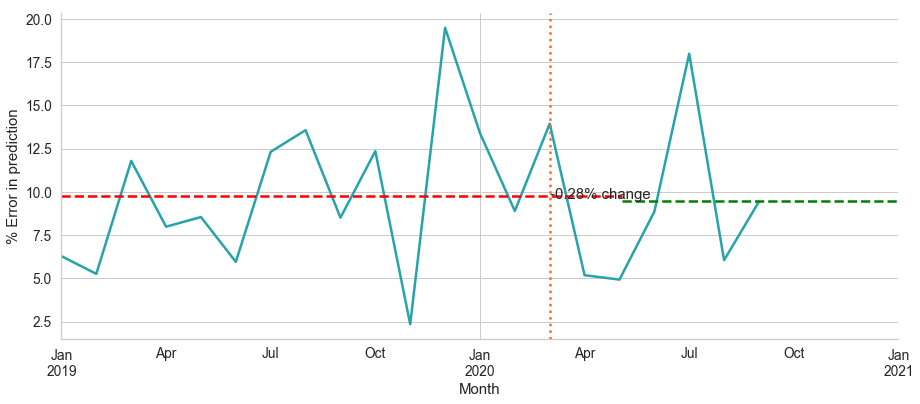

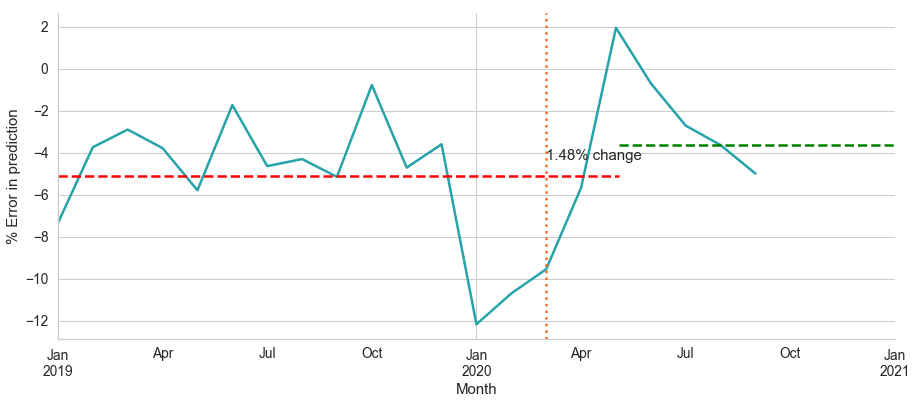

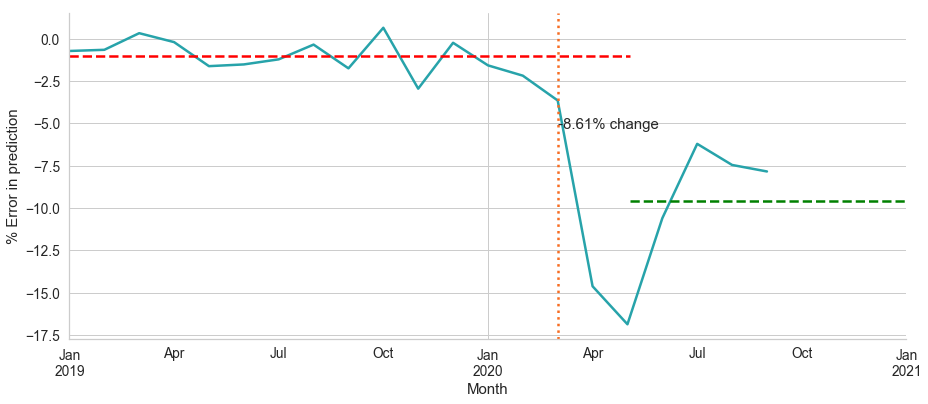

In [33]:
# fig,ax = plt.subplots(3 ,2,figsize=(10,6))
state_plot(energy_data,'FL','RES',year_lim=2019)
state_plot(energy_data,'FL','COM',year_lim=2019)
state_plot(energy_data,'NY','RES',year_lim=2019)
state_plot(energy_data,'NY','COM',year_lim=2019)
state_plot(energy_data,'AL','RES',year_lim=2019)
state_plot(energy_data,'AL','COM',year_lim=2019)
state_plot(energy_data,'TX','RES',year_lim=2019)
state_plot(energy_data,'TX','COM',year_lim=2019)
state_plot(energy_data,'CA','RES',year_lim=2019)
state_plot(energy_data,'CA','COM',year_lim=2019)
state_plot(energy_data,'USA','RES',year_lim=2019)
state_plot(energy_data,'USA','COM',year_lim=2019)


### Training with 2019 data

In [34]:
# %%timeit
states = list(energy_data.state.unique())
sectors = list(energy_data.sector.unique())
years = [2015,2016,2017,2018,2019,2020]
idx = 0

for year in years:
    for state in states:
        for sector in sectors:
        
            state_sector = "{}-{}".format(state, sector)
#             print(state_sector)
            ## Defining Training Data 
            df_model = energy_data[(energy_data.state == state)&(energy_data.sector == sector)].copy().set_index('date').sort_index()
            df_train, df_test = utils.prepare_data(df_model[['y','heating_days','cooling_days','pct_weekdays']], year)
            regressors_df = df_model[['heating_days','cooling_days','pct_weekdays']].copy()

            ## Fitting model
            m = Prophet(seasonality_mode='multiplicative',yearly_seasonality=5,
                        daily_seasonality=False,weekly_seasonality=False,mcmc_samples=300,
                        changepoint_prior_scale=0.25, changepoint_range=0.95)
            m.add_regressor('heating_days', mode='additive')
            m.add_regressor('cooling_days', mode='additive')
            m.add_regressor('pct_weekdays', mode='additive')
            m_fit = m.fit(df_train,control={'max_treedepth': 15})

            ## Getting forecasts
            future = m_fit.make_future_dataframe(periods = 12, freq = 'MS')
            future = utils.add_regressor_to_future(future, regressors_df)
            forecast = m_fit.predict(future)
            # fig = m_fit.plot(forecast)
            forecast['state'] = state
            forecast['sector'] = sector
            forecast['pred_year'] = year

            if idx == 0:
                predictions = forecast[['ds','yhat','state','sector','pred_year']].copy()    
            else:
                predictions = predictions.append(forecast[['ds','yhat','state','sector','pred_year']])

            idx = idx +1


In [35]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,cooling_days,...,pct_weekdays,pct_weekdays_lower,pct_weekdays_upper,yearly,yearly_lower,yearly_upper,yhat,state,sector,pred_year
151,2020-08-01,195.322098,217.508481,227.052324,191.467831,198.989463,15.512962,12.118821,18.958690,27.117473,...,-0.381978,-0.460282,-0.299835,0.058818,0.043970,0.073531,222.323567,USA,COM,2020
152,2020-09-01,195.048974,205.888904,216.443428,190.853427,199.145064,-1.882838,-3.388788,-0.394326,7.143834,...,0.545977,0.428568,0.657901,0.092003,0.084427,0.100510,211.111155,USA,COM,2020
153,2020-10-01,194.784661,185.214432,196.050940,189.991458,199.364428,-7.886825,-8.629015,-7.137586,-4.057720,...,-0.381978,-0.460282,-0.299835,0.018720,0.013130,0.024073,190.544173,USA,COM,2020
154,2020-11-01,194.511537,173.897385,185.214529,189.284618,199.561326,-9.862838,-11.204405,-8.614702,-9.879608,...,-2.193700,-2.643403,-1.721955,-0.025672,-0.034322,-0.017362,179.655204,USA,COM,2020
155,2020-12-01,194.247224,176.039870,187.676447,188.355240,199.832424,1.020949,-1.100085,3.285664,-12.727229,...,0.943672,0.740740,1.137123,-0.068219,-0.079810,-0.057213,182.016906,USA,COM,2020


In [36]:
predictions.state.value_counts()

WA     1512
GA     1512
NJ     1512
WV     1512
ME     1512
TN     1512
VA     1512
MN     1512
OK     1512
SD     1512
ND     1512
IL     1512
WI     1512
USA    1512
PA     1512
WY     1512
SC     1512
AL     1512
CT     1512
VT     1512
FL     1512
NM     1512
OH     1512
MT     1512
MI     1512
NY     1512
NH     1512
AR     1512
IN     1512
LA     1512
ID     1512
RI     1512
AZ     1512
MD     1512
KY     1512
IA     1512
MS     1512
NE     1512
NC     1512
NV     1512
OR     1512
CO     1512
MO     1512
KS     1512
CA     1512
TX     1512
DC     1512
UT     1512
DE     1512
MA     1512
Name: state, dtype: int64

In [37]:
pred_over_time = predictions[predictions.ds.dt.year==predictions.pred_year].merge(energy_data[['y','date','state','sector']],how='left',left_on=['ds','state','sector'],right_on=['date','state','sector'])

In [38]:
pred_over_time['pct_error'] = (pred_over_time['y'] - pred_over_time['yhat'])*100/pred_over_time['y']

In [39]:
pred_over_time[(pred_over_time.sector=='RES')&(pred_over_time.ds >= '2020-03-01')].sort_values('pct_error')

,ds,yhat,state,sector,pred_year,y,date,pct_error
7065,2020-10-01,27.119466,VA,RES,2020,22.112530,2020-10-01,-22.642980
6146,2020-03-01,21.056205,DC,RES,2020,18.712318,2020-03-01,-12.525907
6866,2020-03-01,26.631849,PA,RES,2020,23.676767,2020-03-01,-12.480938
6779,2020-12-01,47.285361,ND,RES,2020,42.218310,2020-12-01,-12.002023
6698,2020-03-01,18.419644,NM,RES,2020,16.615543,2020-03-01,-10.857915
...,...,...,...,...,...,...,...,...
6172,2020-05-01,20.243488,DE,RES,2020,24.592314,2020-05-01,17.683679
6484,2020-05-01,15.308504,MI,RES,2020,18.724421,2020-05-01,18.243113
6896,2020-09-01,16.980805,RI,RES,2020,21.102041,2020-09-01,19.530033
6634,2020-11-01,17.211344,NV,RES,2020,22.014740,2020-11-01,21.818998


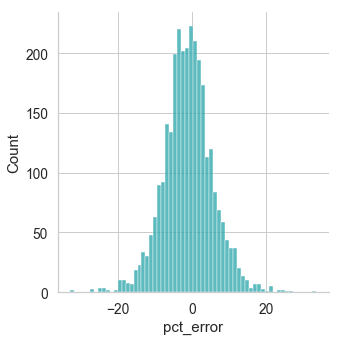

In [40]:
# fig,ax = plt.subplots(figsize=(10,8))
sns.displot(pred_over_time[(pred_over_time.ds.dt.year<2020)&(pred_over_time.sector=='RES')].pct_error)

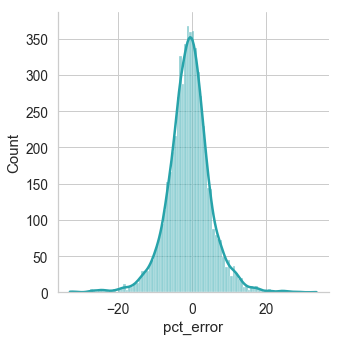

In [41]:
# fig,ax = plt.subplots(figsize=(10,8))
sns.displot(pred_over_time[(pred_over_time.ds.dt.year<2020)].pct_error, kde=True)


In [42]:
pred_over_time[(pred_over_time.ds.dt.year<2020)].pct_error.quantile([0.05,0.1,0.9,0.95])

0.05   -10.132066
0.10    -7.402483
0.90     5.798778
0.95     8.570966
Name: pct_error, dtype: float64

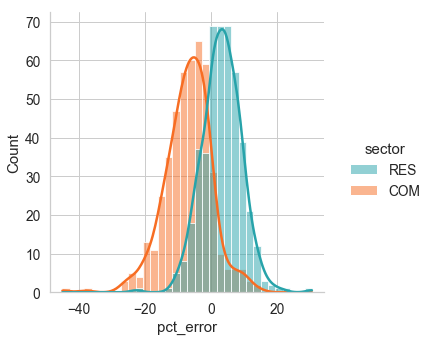

In [43]:
# fig,ax = plt.subplots(figsize=(10,8))
sns.displot(data=pred_over_time[(pred_over_time.ds > '2020-03-01')], x='pct_error', kde=True, hue='sector')

In [44]:
pred_over_time[(pred_over_time.ds >= '2020-03-01')&(pred_over_time.sector=='COM')].pct_error.median()

-5.90204475184586

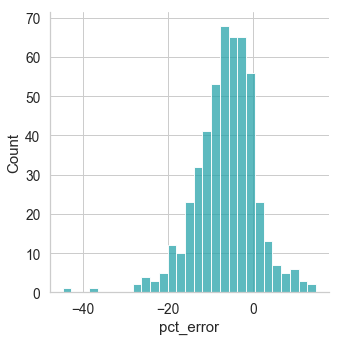

In [45]:
# fig,ax = plt.subplots(figsize=(10,8))
sns.displot(pred_over_time[(pred_over_time.ds >= '2020-03-01')&(pred_over_time.sector=='COM')].pct_error)

In [46]:
predictions_2020 = predictions[predictions.pred_year==2020].rename(columns={'ds':'date','yhat':'yhat_20'})
energy_data = energy_data.merge(predictions_2020,how='left',on=['date','state','sector'])

In [47]:
energy_data['pct_error_20'] = (energy_data['y'] - energy_data['yhat_20'])*100/energy_data['y']

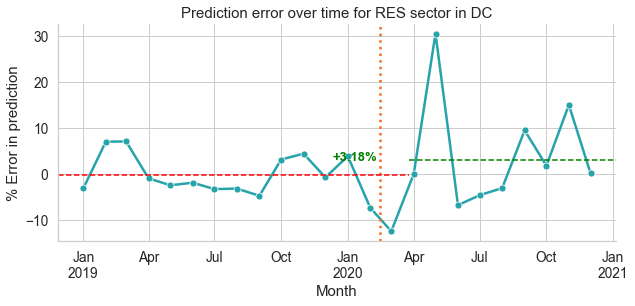

In [48]:
utils.state_plot(energy_data,'DC','RES',year_lim=2019,col='pct_error_20')

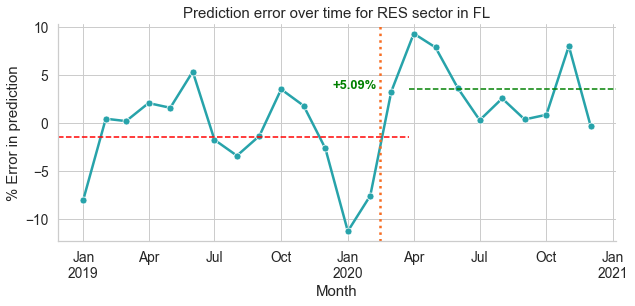

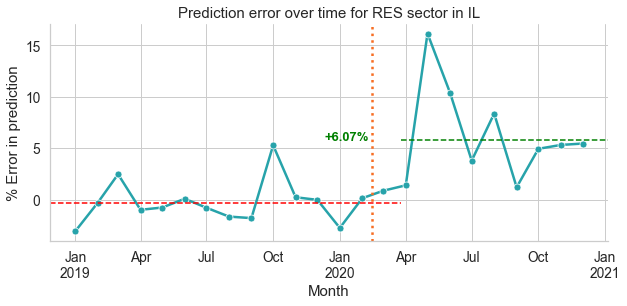

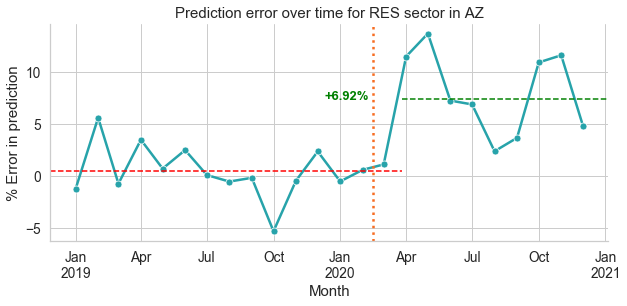

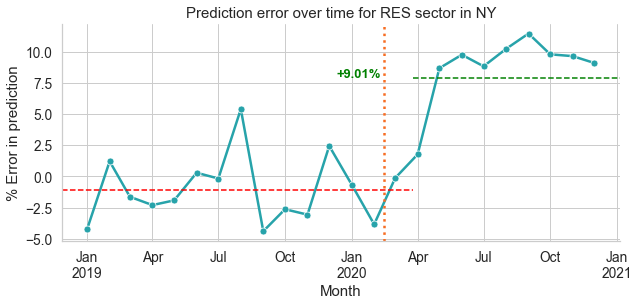

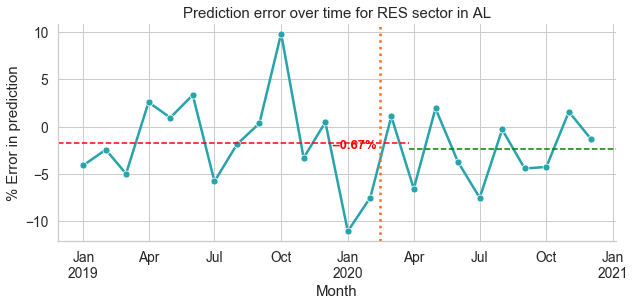

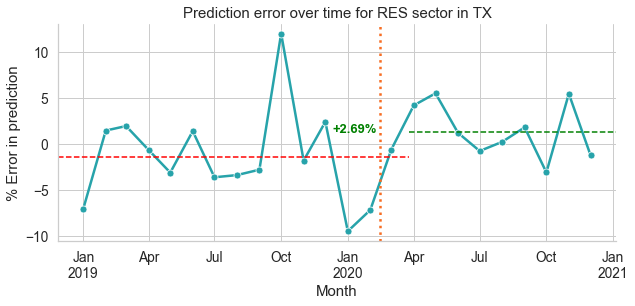

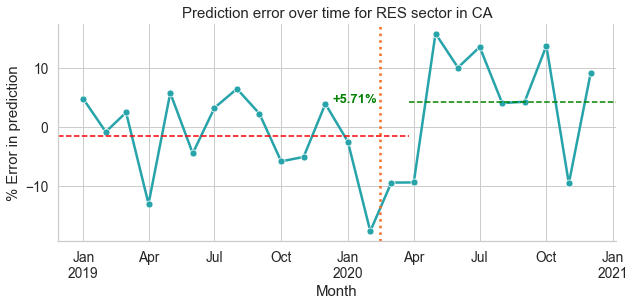

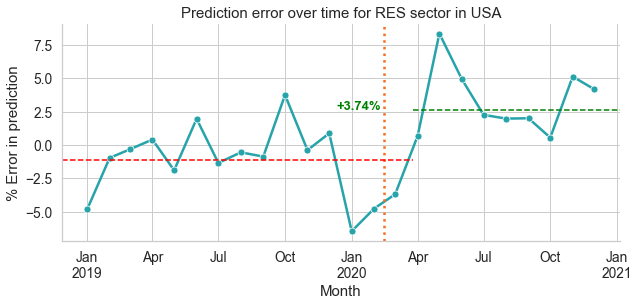

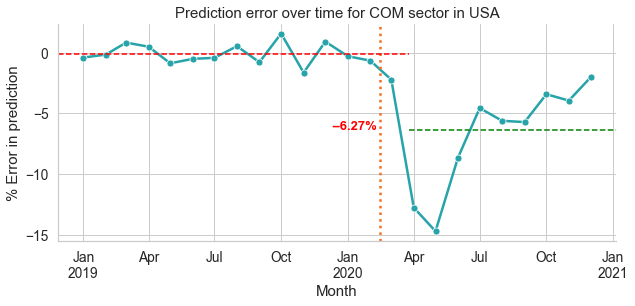

In [49]:
# fig,ax = plt.subplots(3 ,2,figsize=(10,6))
utils.state_plot(energy_data,'FL','RES',year_lim=2019,col='pct_error_20')
utils.state_plot(energy_data,'IL','RES',year_lim=2019,col='pct_error_20')
utils.state_plot(energy_data,'AZ','RES',year_lim=2019,col='pct_error_20')
# utils.state_plot(energy_data,'FL','COM',year_lim=2019,col='pct_error_20')
utils.state_plot(energy_data,'NY','RES',year_lim=2019,col='pct_error_20')
# utils.state_plot(energy_data,'NY','COM',year_lim=2019,col='pct_error_20')
utils.state_plot(energy_data,'AL','RES',year_lim=2019,col='pct_error_20')
# utils.state_plot(energy_data,'AL','COM',year_lim=2019,col='pct_error_20')
utils.state_plot(energy_data,'TX','RES',year_lim=2019,col='pct_error_20')
# utils.state_plot(energy_data,'TX','COM',year_lim=2019,col='pct_error_20')
utils.state_plot(energy_data,'CA','RES',year_lim=2019,col='pct_error_20')
# utils.state_plot(energy_data,'CA','COM',year_lim=2019,col='pct_error_20')
utils.state_plot(energy_data,'USA','RES',year_lim=2019,col='pct_error_20')
utils.state_plot(energy_data,'USA','COM',year_lim=2019,col='pct_error_20')


In [50]:
def mean_errors(df, col='pct_error_20'):
    pre_covid = df[(df.date<'2020-03-01')&(df.date >= '2019-01-01')][col].mean()
    post_covid = df[df.date>='2020-03-01'][col].mean()
    diff = post_covid - pre_covid
    return diff
#     return {'pre_covid':pre_covid, 'post_covid':post_covid}

In [51]:
mean_change = pd.DataFrame(energy_data.groupby(['state','sector']).apply(mean_errors).reset_index().rename(columns={0:'change'}))

In [52]:
mean_res_change = mean_change[mean_change.sector=="RES"]

In [53]:
mean_res_change

,state,sector,change
1,AL,RES,-0.667382
3,AR,RES,-2.054145
5,AZ,RES,6.917644
7,CA,RES,5.709638
9,CO,RES,4.941269
11,CT,RES,7.425826
13,DC,RES,3.177062
15,DE,RES,5.426365
17,FL,RES,5.087904
19,GA,RES,-0.517735


In [54]:
gdf = gpd.read_file('us_states/cb_2018_us_state_5m.shp')

In [55]:
gdf = gdf[gdf.STUSPS.isin(mean_res_change.state)]

In [56]:
gdf = gdf.to_crs("EPSG:2163")

In [57]:
gdf = gdf.merge(mean_res_change, how='left',left_on='STUSPS',right_on='state')

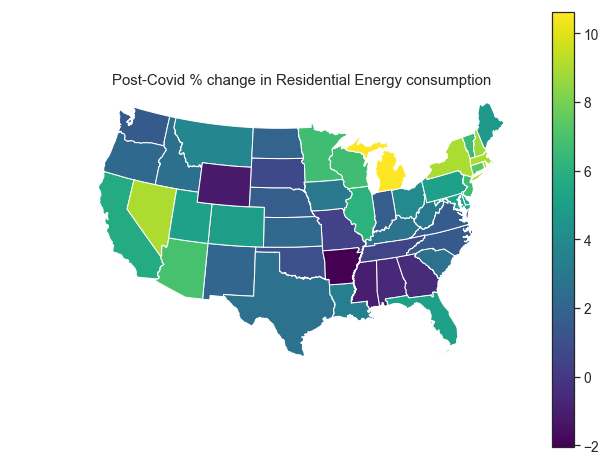

In [58]:
sns.set_style('white')
fig,ax = plt.subplots(figsize=(10,8))
gdf.plot(column='change',ax=ax, legend=True, cmap='viridis')
plt.title("Post-Covid % change in Residential Energy consumption")
ax.set_axis_off()

In [59]:
energy_data.to_csv('energy_data_with_predictions.csv',index=False)

## Statsmodels Time-series analysis

In [ ]:
ts = energy_data[(energy_data.sector=='RES')].copy()
ts['date'] = ts.month + '01'
ts.set_index('date', inplace=True)
ts.index = pd.to_datetime(ts.index)

In [ ]:
state_dummies = pd.get_dummies(ts['state'])
ts = pd.concat([ts,state_dummies],axis=1)

In [ ]:
state_dummies.columns

In [ ]:
from statsmodels.tsa.seasonal import STL

In [ ]:
exog.dropna()

In [ ]:
energy_data['t'] = [x+'01' for x in energy_data.month]
energy_data['date'] = pd.to_datetime(energy_data.t)

In [ ]:
fig,ax = plt.subplots(figsize=(20,10))
sns.lineplot(x='date',y='use_per_capita',data=energy_data[(energy_data.state=='NY')&(energy_data.sector=='RES')])
plt.ylabel('Montly Use per capita (kwh)')
plt.xlabel('Month')

## Modeling with statsmodels

In [ ]:
## divide by number of days per month
## Weekends per month


In [ ]:
## GEt NY ISO granular data (15 min resolution)

In [ ]:
state_level_data =  energy_data[energy_data.state != 'USA'].copy()

In [ ]:
state_level_data['year_l1'] = state_level_data.year - 1
state_level_data['mon_l1'] = state_level_data.mon - 1
state_level_data = state_level_data.merge(state_level_data[['year','mon','state','sector','use_per_capita']].rename(columns={'year':'year_l1','use_per_capita':'y_sl1'}),how='left',left_on=['year_l1','mon','state','sector'],right_on=['year_l1','mon','state','sector'])
state_level_data = state_level_data.merge(state_level_data[['year','mon','state','sector','use_per_capita']].rename(columns={'mon':'mon_l1','use_per_capita':'y_l1'}),how='left',left_on=['year','mon_l1','state','sector'],right_on=['year','mon_l1','state','sector'])

In [ ]:
state_level_data.head()

In [ ]:
state_level_data = state_level_data.dropna()

In [ ]:
state_level_data['yhat'] = np.NaN
# state_level_data['yhat_20'] = np.NaN

In [ ]:
mod_19_res = smf.ols(formula='use_per_capita ~  time + y_sl1 + heating_days + cooling_days + C(state)', data=state_level_data[(state_level_data.year < 2019)&(state_level_data.sector=='RES')])
mod_20_res = smf.ols(formula='use_per_capita ~  time + y_sl1 + heating_days + cooling_days + C(state)', data=state_level_data[(state_level_data.year < 2020)&(state_level_data.sector=='RES')])
mod_19_com = smf.ols(formula='use_per_capita ~  time + y_sl1 + heating_days + cooling_days + C(state)', data=state_level_data[(state_level_data.year < 2019)&(state_level_data.sector=='COM')])
mod_20_com = smf.ols(formula='use_per_capita ~  time + y_sl1 + heating_days + cooling_days + C(state)', data=state_level_data[(state_level_data.year < 2020)&(state_level_data.sector=='COM')])

In [ ]:
res_19_res = mod_19_res.fit()
res_20_res = mod_20_res.fit()
res_19_com = mod_19_com.fit()
res_20_com = mod_20_com.fit()



In [ ]:
# md = smf.mixedlm('use_per_capita ~ time + time^2 + y_l1 + heating_days + cooling_days', data=state_level_data[(state_level_data.year < 2019)&(state_level_data.sector=='COM')&(state_level_data.region=='ESC')], groups=state_level_data[(state_level_data.year < 2019)&(state_level_data.sector=='COM')&(state_level_data.region=='ESC')]["state"])
# mdf = md.fit()
# print(mdf.summary())

In [ ]:
print(res_19_com.summary())

## To Do:
- Outcome variable: Average per day
- % of days that are weekends or holidays
- 1 month lagged (AR-1), last 3 month average
- % above last 12m avg usage

- Stan model
- Take pieces from Prophet (fourier expansion for seasonality): get the stan code
- weather data maybe

In [ ]:
state_level_data.set_index('date',inplace=True)

In [ ]:
state_level_data.loc[(state_level_data.year<=2019)&(state_level_data.sector=='RES'),'yhat'] = res_19_res.predict(state_level_data[(state_level_data.year<=2019)&(state_level_data.sector=='RES')])
state_level_data.loc[(state_level_data.year==2020)&(state_level_data.sector=='RES'),'yhat'] = res_20_res.predict(state_level_data[(state_level_data.year==2020)&(state_level_data.sector=='RES')])
state_level_data.loc[(state_level_data.year<=2019)&(state_level_data.sector=='COM'),'yhat'] = res_19_com.predict(state_level_data[(state_level_data.year<=2019)&(state_level_data.sector=='COM')])
state_level_data.loc[(state_level_data.year==2020)&(state_level_data.sector=='COM'),'yhat'] = res_20_com.predict(state_level_data[(state_level_data.year==2020)&(state_level_data.sector=='COM')])

In [ ]:
fig,ax = plt.subplots(figsize=(20,10))
df_plot = state_level_data[(state_level_data.state=='NY')&(state_level_data.sector=='RES')].copy()
df_plot = df_plot.set_index('date')
df_plot.loc[df_plot.year == 2020, 'yhat'] = np.NaN
df_plot = df_plot[['use_per_capita','yhat']].rename(columns={'use_per_capita':'Actual','yhat':'Predicted'})
sns.lineplot(data=df_plot)
plt.ylabel('Montly Use per capita (kwh)')
plt.xlabel('Month')


In [ ]:
state_level_data['pct_error'] = (state_level_data['use_per_capita'] - state_level_data['yhat'])*100/state_level_data['use_per_capita']
# state_level_data['pct_error_20'] = (state_level_data['yhat_20'] - state_level_data['use_per_capita'])*100/state_level_data['use_per_capita']

In [ ]:
sns.boxplot(x='sector',y='pct_error',data=state_level_data)

In [ ]:
state_level_data = state_level_data.set_index('month').sort_index()

In [ ]:
state_level_data[(state_level_data.mon == 2)&(state_level_data.state=='CA')&(state_level_data.sector=='RES')].use_per_capita.plot()

In [ ]:
sns.boxplot(x='mon',y='pct_error',data=state_level_data[state_level_data.sector=='COM'])

In [ ]:
sns.boxplot(x='mon',y='pct_error_19',data=state_level_data[state_level_data.sector=='RES'])

In [ ]:
sns.boxplot(x='mon',y='pct_error_19',data=state_level_data[state_level_data.sector=='COM'])

In [ ]:
fig,ax = plt.subplots(figsize=(20,10))
sns.boxplot(x='state',y='pct_error_19',data=state_level_data[state_level_data.sector=='RES'])

In [ ]:
fig,ax = plt.subplots(figsize=(20,10))
sns.boxplot(x='state',y='pct_error_19',data=state_level_data[state_level_data.sector=='COM'])

In [ ]:
state_level_data.pct_error_19.plot()

In [ ]:
df_plot = state_level_data[(state_level_data.state == 'NY')&(state_level_data.sector=='RES')&(state_level_data.year>=2019)]

In [ ]:
df_plot.set_index('month').sort_index().pct_error.plot()

In [ ]:
df_plot = state_level_data[(state_level_data.state == 'NY')&(state_level_data.sector=='COM')&(state_level_data.year>=2019)]

In [ ]:
df_plot.set_index('month').sort_index().pct_error.plot()

In [ ]:
state_level_data.head()

In [ ]:
state_level_data.reset_index(inplace=True)

In [32]:
def state_plot(df, state, sector, year_lim=2019):
    df_plot = df[(df.state==state)&(df.sector==sector)&(df.year>=year_lim)].copy()
    fig,ax = plt.subplots(figsize=(15,6))
    mean_error_before = df_plot[(df_plot.date<'2020-03-01')].pct_error.mean()
    mean_error_after = df_plot[(df_plot.date>='2020-03-01')].pct_error.mean()
    
    df_plot = df_plot.set_index('date')
    df_plot.pct_error.plot(ax=ax)
    plt.xlabel('Month')
    plt.ylabel('% Error in prediction')
    plt.axvline(x=datetime(2020,3,1),color='#f76d23',linestyle='dotted')
    plt.axhline(y=mean_error_before, xmin=0, xmax=0.67, color='r', linestyle='--')
    plt.axhline(y=mean_error_after, xmin=0.67, xmax=1, color='g', linestyle='--')
    plt.text(x=datetime(2020,3,1),y=((mean_error_after+mean_error_before)/2),s= "{}% change".format(np.round(mean_error_after-mean_error_before,2)))
    
#     plt.axvline()

In [ ]:
state_plot(state_level_data,'NY','RES')

In [ ]:
state_plot(state_level_data,'NY','COM')